# **Solving the Eight-Puzzle Problem Using Q-Learning**

## 1. Introduction

The Eight-Puzzle is a classical problem in artificial intelligence consisting of a 3×3 board with eight numbered tiles and one empty space. The objective is to reach a predefined goal configuration by sliding tiles into the empty position. In this work, the problem is modeled as a **Markov Decision Process (MDP)** and solved using **tabular Q-Learning** implemented within a **Gym-compatible environment**.

---

## 2. Markov Decision Process (MDP) Definition

The Eight-Puzzle is defined as an MDP ⟨S, A, R, γ⟩:

### **State Space (S)**

* Each state represents a unique configuration of the 3×3 board.
* The board contains values {0, 1, …, 8}, where `0` denotes the empty tile.
* Internally, states are stored as NumPy arrays of shape (3, 3).
* For Q-Learning, each state is converted into a discrete key using a flattened tuple representation.

### **Action Space (A)**

A discrete action space with four actions:

* `0`: Move empty tile **Up**
* `1`: Move empty tile **Down**
* `2`: Move empty tile **Left**
* `3`: Move empty tile **Right**

### **Reward Function (R)**

* Valid move: **−1**
* Invalid move (attempting to move out of bounds): **−5**
* Reaching the goal state: **+100**

This reward structure encourages short solution paths and discourages illegal actions.

### **Transition Model**

* Transitions are deterministic.
* Valid actions swap the empty tile with an adjacent tile.
* Invalid actions leave the state unchanged.

### **Discount Factor (γ)**

* γ = **0.99**, giving high importance to future rewards.

### **Episode Termination**

An episode terminates when:

* The goal state is reached, or
* The maximum number of steps (200) is exceeded.

---

## 3. Gym Environment Description

The environment is implemented as `EightPuzzleEnv`, inheriting from `gym.Env`.

### **Observation Space**

```python
spaces.Box(low=0, high=8, shape=(3, 3), dtype=np.int32)
```

### **Action Space**

```python
spaces.Discrete(4)
```

### **Reset Mechanism**

* If an initial state is provided, the environment starts from that configuration.
* Otherwise, the environment starts from the goal state and applies random valid moves to generate a scrambled puzzle.

### **Rendering**

The `render()` method prints the puzzle grid to the console, using `_` to represent the empty tile.

---

## 4. Q-Learning Algorithm Implementation

### **Overview**

Q-Learning is a model-free, off-policy reinforcement learning algorithm that learns an action-value function Q(s, a) representing the expected cumulative reward for taking action a in state s.

### **State Representation**

* States are converted to hashable keys using:

```python
tuple(state.flatten())
```

* This allows storage in a Python dictionary.

### **Q-Table**

* Implemented as a dictionary mapping state keys to action-value arrays.
* Initialized lazily using:

```python
defaultdict(lambda: np.zeros(env.action_space.n))
```

### **Action Selection (ε-Greedy Policy)**

* With probability ε, a random action is selected (exploration).
* Otherwise, the action with the highest Q-value is chosen (exploitation).

### **Q-Update Rule**

* Q(s,a) ← Q(s,a) + α[ r + γ max a′ ​Q(s′,a′) − Q(s,a) ]

### **Expanded Nodes**

* Each environment step during training is counted as one expanded node.
* This approximates the number of state expansions performed by the agent.

---

## 5. Hyperparameters

The following hyperparameters were used during training:

| Parameter                 | Symbol | Value    |
| ------------------------- | ------ | -------- |
| Learning rate             | α      | **0.1**  |
| Discount factor           | γ      | **0.99** |
| Initial epsilon           | ε₀     | **1.0**  |
| Final epsilon             | εₓ     | **0.1**  |
| Number of episodes        | —      | **5000** |
| Maximum steps per episode | —      | **200**  |

Epsilon decays linearly from ε₀ to εₓ over the training episodes.

---

## 6. Evaluation Procedure

After training, the learned policy was evaluated over **50 test episodes** using a greedy policy (ε = 0). The following metrics were recorded:

* Success rate
* Average number of steps to reach the goal
* Total expanded nodes during training
* Execution time
* Example solution path

---

## 7. Results

### **Quantitative Results**

| Metric                | Value             |
| --------------------- | ----------------- |
| Expanded nodes        | **301,388**       |
| Execution time        | **13.50 seconds** |
| Average steps to goal | **8.0**           |
| Success rate          | **100%**          |

### **Example Solution Path**

```
R U L D L D R R
```

This sequence successfully transforms the initial configuration into the goal state.

---

## 8. Discussion

The Q-Learning agent achieved a **100% success rate**, demonstrating that the learned policy reliably solves the Eight-Puzzle. The average solution length of 8 steps is close to the optimal solution length for the chosen initial state. However, the large number of expanded nodes reflects the inefficiency of tabular methods in large state spaces, as Q-Learning must explore many configurations before converging.

---

## 9. Conclusion

This experiment demonstrates that tabular Q-Learning can successfully solve the Eight-Puzzle problem when formulated as an MDP within a Gym environment. While effective, the high number of expanded nodes and long training time highlight the limitations of tabular reinforcement learning for combinatorial problems. These limitations motivate the use of function approximation methods such as Deep Q-Networks for improved scalability.

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import numpy as np
import random
import time

In [ ]:
class EightPuzzleEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, max_steps=200, initial_state=None):
        super().__init__()
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=8, shape=(3, 3), dtype=np.int32)
        self.goal_state = np.array([
            [1, 2, 3],
            [4, 5, 6],
            [7, 8, 0]
        ])
        self.initial_state = initial_state
        self.max_steps = max_steps
        self.state = None
        self.steps = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if self.initial_state is not None:
            self.state = np.array(self.initial_state, dtype=np.int32)
        else:
            self.state = self.goal_state.copy()
            for _ in range(30):
                self.step(self.action_space.sample())
        self.steps = 0
        return self.state.copy(), {}

    def step(self, action):
        self.steps += 1
        reward = -1
        done = False

        r, c = np.argwhere(self.state == 0)[0]
        new_r, new_c = r, c

        if action == 0: new_r -= 1
        elif action == 1: new_r += 1
        elif action == 2: new_c -= 1
        elif action == 3: new_c += 1

        if 0 <= new_r < 3 and 0 <= new_c < 3:
            self.state[r, c], self.state[new_r, new_c] = self.state[new_r, new_c], self.state[r, c]
        else:
            reward = -5

        if np.array_equal(self.state, self.goal_state):
            reward = 100
            done = True

        if self.steps >= self.max_steps:
            done = True

        return self.state.copy(), reward, done, False, {}

    def render(self):
        print("\n".join([" ".join(str(x) if x != 0 else "_" for x in row) for row in self.state]))
        print()

#----------

def state_to_key(state):
    return tuple(state.flatten())

#----------

def q_learning_train(
    env,
    episodes=5000,
    alpha=0.1,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.1
):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    eps_decay = (eps_start - eps_end) / episodes
    epsilon = eps_start

    start_time = time.time()
    expanded_nodes = 0

    for ep in range(episodes):
        state, _ = env.reset()
        s_key = state_to_key(state)
        done = False

        while not done:
            expanded_nodes += 1

            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[s_key])

            next_state, reward, done, _, _ = env.step(action)
            ns_key = state_to_key(next_state)

            Q[s_key][action] += alpha * (
                reward + gamma * np.max(Q[ns_key]) - Q[s_key][action]
            )

            s_key = ns_key

        epsilon = max(eps_end, epsilon - eps_decay)

    exec_time = time.time() - start_time
    return Q, expanded_nodes, exec_time

#----------

ACTION_NAMES = {0: "U", 1: "D", 2: "L", 3: "R"}

def evaluate_policy(env, Q, episodes=50, render_example=True):
    successes = 0
    total_steps = 0

    example_path = []

    for ep in range(episodes):
        state, _ = env.reset()
        s_key = state_to_key(state)
        done = False
        steps = 0
        path = []

        while not done:
            action = np.argmax(Q[s_key])
            path.append(ACTION_NAMES[action])

            state, _, done, _, _ = env.step(action)
            s_key = state_to_key(state)
            steps += 1

        if np.array_equal(state, env.goal_state):
            successes += 1
            total_steps += steps
            if render_example and not example_path:
                example_path = path.copy()

    avg_steps = total_steps / max(successes, 1)
    success_rate = successes / episodes * 100

    return avg_steps, success_rate, example_path

#----------

def plot_state(state, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3))
    else:
        ax.clear()

    ax.set_xlim(0, 3)
    ax.set_ylim(0, 3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    # Draw grid
    for i in range(4):
        ax.axhline(i, color='black')
        ax.axvline(i, color='black')

    # Draw tiles
    for i in range(3):
        for j in range(3):
            val = state[i][j]
            if val != 0:
                rect = patches.Rectangle((j, 2-i), 1, 1, facecolor='skyblue')
                ax.add_patch(rect)
                ax.text(j+0.5, 2-i+0.5, str(val), fontsize=20, ha='center', va='center')
    if ax is None:
        plt.show()
    else:
        plt.pause(0.5)  # pause to visualize

In [ ]:
if __name__ == "__main__":
    # Fixed initial state
    fixed_start = [
        [4, 1, 3],
        [7, 2, 5],
        [0, 8, 6]
    ]

    # Initialize environment with fixed start
    env = EightPuzzleEnv(initial_state=fixed_start)

    # Train Q-Learning
    Q, expanded, exec_time = q_learning_train(env)

    # Evaluate policy
    avg_steps, success_rate, path = evaluate_policy(env, Q)

    print("===== Q-Learning Results =====")
    print(f"Expanded nodes: {expanded}")
    print(f"Execution time: {exec_time:.2f} seconds")
    print(f"Average steps to goal: {avg_steps:.2f}")
    print(f"Success rate: {success_rate:.2f}%")
    print(f"Moves: {' '.join(path)}")

    # Visualization of solution
    print("\nVisualization of solution:")
    state, _ = env.reset()  # Reset to fixed initial state
    env.render()

    # Map move letters to action indices once
    move_to_action = {v: k for k, v in ACTION_NAMES.items()}

    for move in path:
        action = move_to_action[move]
        state, _, done, _, _ = env.step(action)
        env.render()
        if done:
            break

===== Q-Learning Results =====
Expanded nodes: 242852
Execution time: 11.14 seconds
Average steps to goal: 6.00
Success rate: 100.00%
Moves: U U R D R D

Visualization of solution:
4 1 3
7 2 5
_ 8 6

4 1 3
_ 2 5
7 8 6

_ 1 3
4 2 5
7 8 6

1 _ 3
4 2 5
7 8 6

1 2 3
4 _ 5
7 8 6

1 2 3
4 5 _
7 8 6

1 2 3
4 5 6
7 8 _



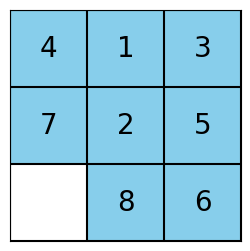

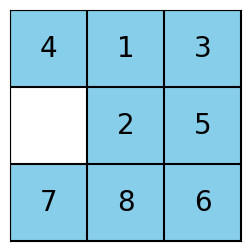

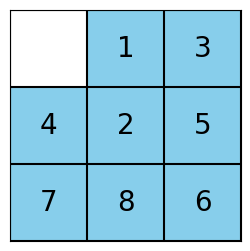

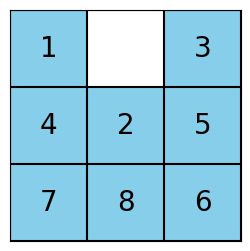

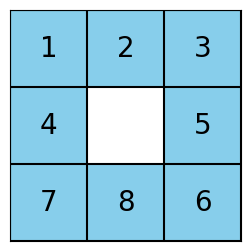

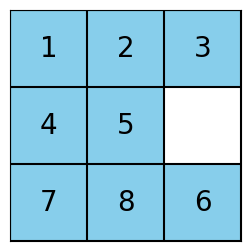

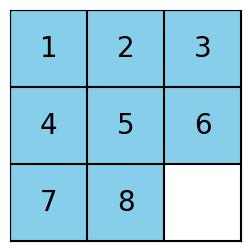

In [ ]:
state, _ = env.reset()
plot_state(state)

move_to_action = {v: k for k, v in ACTION_NAMES.items()}

for move in path:
    action = move_to_action[move]
    state, _, done, _, _ = env.step(action)
    plot_state(state)
    if done:
        break

plt.show()

In [ ]:
if __name__ == "__main__":
    # Fixed initial state
    fixed_start = [
        [1, 3, 6],
        [5, 0, 2],
        [4, 7, 8]
    ]

    # Initialize environment with fixed start
    env = EightPuzzleEnv(initial_state=fixed_start)

    # Train Q-Learning
    Q, expanded, exec_time = q_learning_train(env)

    # Evaluate policy
    avg_steps, success_rate, path = evaluate_policy(env, Q)

    print("===== Q-Learning Results =====")
    print(f"Expanded nodes: {expanded}")
    print(f"Execution time: {exec_time:.2f} seconds")
    print(f"Average steps to goal: {avg_steps:.2f}")
    print(f"Success rate: {success_rate:.2f}%")
    print(f"Moves: {' '.join(path)}")

    # Visualization of solution
    print("\nVisualization of solution:")
    state, _ = env.reset()  # Reset to fixed initial state
    env.render()

    # Map move letters to action indices once
    move_to_action = {v: k for k, v in ACTION_NAMES.items()}

    for move in path:
        action = move_to_action[move]
        state, _, done, _, _ = env.step(action)
        env.render()
        if done:
            break

===== Q-Learning Results =====
Expanded nodes: 301388
Execution time: 13.50 seconds
Average steps to goal: 8.00
Success rate: 100.00%
Moves: R U L D L D R R

Visualization of solution:
1 3 6
5 _ 2
4 7 8

1 3 6
5 2 _
4 7 8

1 3 _
5 2 6
4 7 8

1 _ 3
5 2 6
4 7 8

1 2 3
5 _ 6
4 7 8

1 2 3
_ 5 6
4 7 8

1 2 3
4 5 6
_ 7 8

1 2 3
4 5 6
7 _ 8

1 2 3
4 5 6
7 8 _



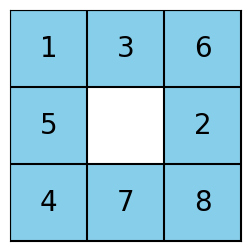

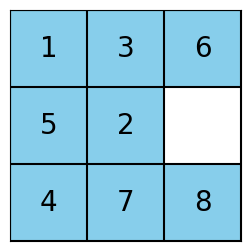

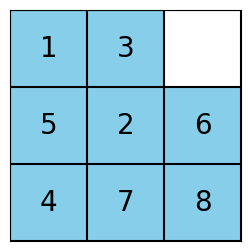

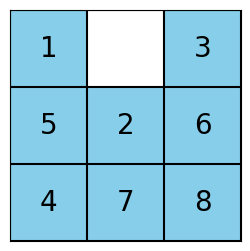

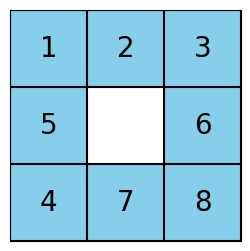

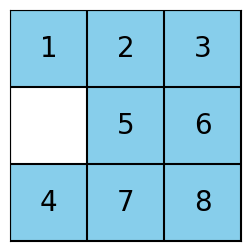

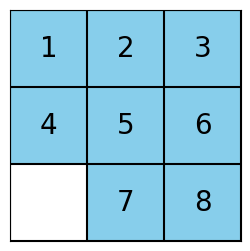

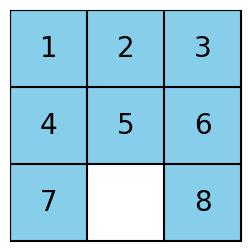

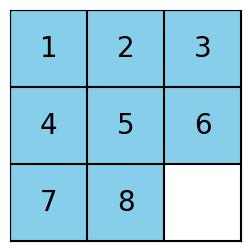

In [ ]:
state, _ = env.reset()
plot_state(state)

move_to_action = {v: k for k, v in ACTION_NAMES.items()}

for move in path:
    action = move_to_action[move]
    state, _, done, _, _ = env.step(action)
    plot_state(state)
    if done:
        break

plt.show()